# Início: 08/10/2021

Imaginemos que façamos uma pergunta complexa a milhares de pessoas e, com isso, reunimos suas respostas. Em diversos casos, veremos que a resposta agregada é melhor do que a resposta de um especialista, conhecido como *sabedoria das multidões*. Do mesmo modo, se agregarmos as previsões de um conjunto de previsores (como os regressores ou os classificadores), muitas vezes obteremos melhores previsões do que com o melhor modelo individual. Um conjunto de previsores é chamado de *ensemble*; dessa maneira, esta técnica é conhecida como *Ensamble Learning*, e o algoritmo é chamado de *Ensemble method*.

Por exemplo, podemos treinar um conjunto de Árvores de Decisão, cada um em um sub conjunto aleatório diferente do conjunto de treino. Para realizar previsões, devemos obtê-las de todas as árvores individuais e, então, prever a classe qe pbtém a maior parte dos votos. Esse ensemble de Árvores de Decisão é conhecido como Floresta Aleatória e, apesar de ser simples se comparado com os modelos que vimos, é um dos algoritmos mais poderosos de AM disponível hoje.

É muito comum ao final de um projeto usar os Ensemble methods para combinar todos os previsores construídos em um só e obter um melhor resultado.

Nesta capítulo, veremos os Ensemble methods mais usados, incluindo *bagging*, *boosting*, *stacking* e mais outros. Além deles, exploraremos as Florestas Aleatórias.

### Classificadores de Votação

Imagine que treinamos alguns classificadores, cada um apresentando uma precisão de 80%. Podemos ter um classificador de Regressão Logística, *k-Nearets Neighbors*, Floresta Aleatória, SVM e mais alguns.

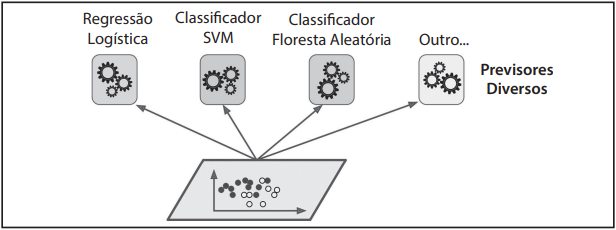

***Figura 7-1. Treinamento de diversos classificadores***

Um jeito smples de criar um classificador ainda melhor é reunir as previsões de cada classificador e prever a classe que possui a maioria dos votos. Este classificador de votos majoritários é conhecido como classificador *hard voting*.

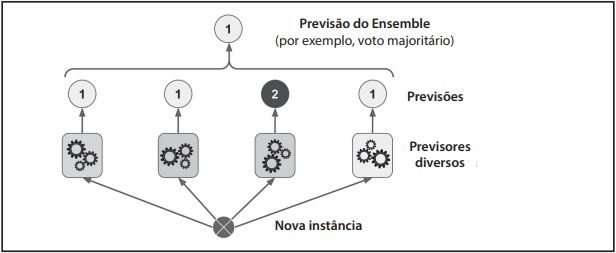

***Figura 7-2. Previsões de um classificador hard voting***

Um pouco surpreendente, este classificador de votação na maior parte das vezes consegue uma maior precisão do que o melhor modelo no *ensenble*. Na verdade, mesmo que cada classificador seja um *aprendiz fraco* (sua classificação é apenas um pouco melhor do que fazer adivinhações aleatórias), o conjnto ainda pode ser um *forte aprendiz* (alta acurácia) desde que exista um número suficiente de aprendizes fracos e que sejam consideravelmente diferentes.

Mas como isso pode acontecer? Uma analogia pode esclarecer essa confusão. Imaginemos que tenhamos uma moeda viciada que possui 51% de chances de ser cara e 49% de ser coroa. Se jogarmos 1000 vezes, teremos 510 caras e 490 coroas, logo, uma maioria de caras. Se fizermos o cálculo, veremos que a probabilidade de ser cara a maior parte dos resultados depois de 1000 lances é de 75%. Se jogarmos a moeda 10 mil vezes, esse valor vai para 97%! Isto é resultado da *lei dos grandes números*: ao continuar a lançar a moeda, a porporção das caras ficam cada vez mais próximas de sua probabilidade teórica (51%). O código abaixo mostra o lançamento de 10 moedas viciadas. Conforme o número de lançamentos cresce, a proporção de caras sempre aproxima-se de 51%. Ao final, todas as 10 séries terminarão tão perto de 51% que sempre estarão acima de 50% *ad infinitum*.

In [1]:
import numpy as np

np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

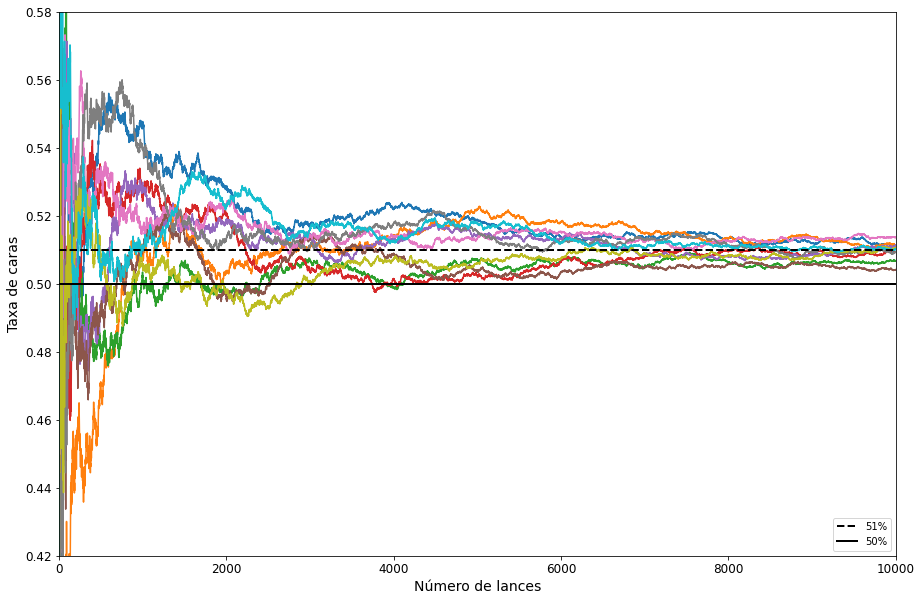

In [3]:
plt.figure(figsize=(15, 10))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=2,
        label='51%')
plt.plot([0, 10000], [0.5, 0.5], 'k-', linewidth=2,
         label='50%')
plt.xlabel('Número de lances')
plt.ylabel('Taxa de caras')
plt.legend(loc='lower right')
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

Agora voltamos aos classificadores. Suponha que criamos um conjunto de 1000 classificadores que estão individualmente corretos em 51% do tempo. Se prevermos a classe votada majoritariamente, é possível obter até 75% de acurácia! Contudo, isso só é possível se todos os classificadores forem independentes, gerando erros não correlacionados; o que não é o caso, uma vez que todos foram treinados com o mesmo conjunto de treino. É possível que poduzam os erros de mesma natureza, então existirá muitos votos majoritários para a classe errada, reduzindo a acurácia do ensemble.

Os métodos *Ensemble* funcionam melhor quando os previsores são independentes entre si. Um modo de ter classificadores diferentes é treiná-los usando algoritmos distintos. Isso aumenta a chance de cometerem erros de natureza diferente, melhorando a acurácia do ensemble.

O código abaixo cria e treina um classificador de votação composto por três classificadores distintos:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [5]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [7]:
log_clf = LogisticRegression(random_state=42,
                             solver='liblinear')
rnd_clf = RandomForestClassifier(random_state=42,
                                 n_estimators=10)
svm_clf = SVC(random_state=42, gamma='auto')

voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf),
            ('svc', svm_clf)])

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(gamma='auto', random_state=42))])

Vejamos a acurácia de cada classificador no conjunto de testes:

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


Olha aí! O classificador de votação supera em alguns pontos todos os classificadores individuais.

Se todos os classificadores conseguem estimar as probabilidades da classe (isto é, possuem o métodod **predict_proba()**), então podemos solicitar ao Scikit-Learn para prever a classe com a maior probabilidade na média sobre todos os classificadores individuais. Isto é conhecido como *soft voting*. Diversas vezes, ele consegue um desepenho maior que o *hard voting*, pois dá mais peso ao votos altamente confiantes. Precisamos somente substituir *hard* por *soft* no hiperparâmetro **voting**. Por padrão, o hiperparâmetro **probability** do **SCV()** é *False*, devemos mudar para *True*. Se modificarmos o código anterior, teremos um classificador com 91% de acurácia:

In [11]:
log_clf = LogisticRegression(random_state=42,
                            solver='liblinear')
rnd_clf = RandomForestClassifier(random_state=42,
                                n_estimators=10)
svm_clf = SVC(random_state=42, probability=True, gamma='auto')

voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf),
            ('svc', svm_clf)], voting='soft')

In [12]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [13]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


### Bagging e Pasting

Como visto no começo do capítulo, uma forma de obter um conjunto diversificado de classificadores é usar algoritmos de treino bem diferentes. Outro caminho seria usar o mesmo algoritmo de treino para cada previsor, mas treiná-lo em diferentes subconjuntos aleatório do conjunto de treino. Quando a amostragem é feita *com substituição*, este modelo é chamado de *bagging* (abreviação para *bootstrap aggregating*). Quando a amostragem é feita *sem* substituição, é chamado de *pasting*.

Em outras palavras, tanto o bagging como o pasting permitem que as instâncias de treino sejam amostradas diversas vezes por meio de vários previsores, mas somente bagging permite que as instâncias de treino sejam amostradas várias vezes pelo mesmo previsor. Este processo está representado na imagem a seguir.

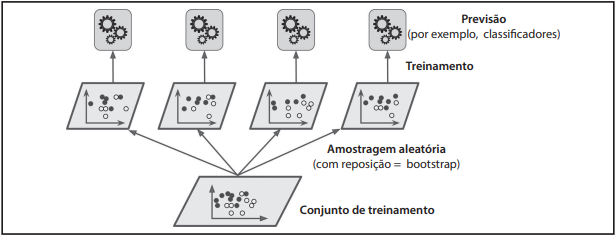

***Figura 7-3. Conjunto de treino e amostragem pasting/bagging***

Uma vez que todos os classificadores estçao treinados, o ensemble pode realizar a previsão para uma nova instância simplesmente agregando as previsões de todos os previsores. A função de aregação é tipicamente *modo estatística*, isto é: a previsão mais frequente, do mesmo modo como um classificador *hard voting*; para a classificação ou a média para a regressão. Cada classificador individual possui um viés mais alto do que se fosse treinado no conjunto original, porém, a agregação reduz tanto o viés como a variância. Na maior parte das vezes, o resultado em rede é que o conjunto possui um viés semelhante, mas uma variância inferior do que um previsor único treinado no conjunto de treino original.

**Bagging e Pasting no Scikit-Learn**

O Scikit-Learn disponibiliza uma API simples tanto para bagging como para pasting com a classe **BaggingClassifier** (para a regeressão, **BaggingRegressor**). O código abaixo treina um conjunto de 500 previsores de Árvore de Decisão, cada um treinado em 100 instâncias de treino amostradas aleatoriamete com substituição no conjunto de treino. Esse é um exemplo de bagging, para transformar em pasting basta informar *False* no hiperparâmetro **bootstrap**. O parâmetro **n_jobs** informa ao Scikit-Learn o número de núcleos de CPU a serem usados para o treino e previsões. Passar -1 diz ao Scikit-Learn para usar todos os núcleos disponíveis:

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [15]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(random_state=42), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

In [16]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1,
                  random_state=42)

In [17]:
print(accuracy_score(y_test, y_pred))

0.912


In [18]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.856


O **BaggingClassifier** executa automaticamente um *soft voting* se o classificador de base puder estimar as probabilidades da classe, ou seja, se tiver um método **predict_proba()**, como nos classificadores de Árvore de Decisão.

O código a seguir compara o limite de decisão de uma única Árvore de Decisão com o de um bagging ensemble de 500 árvores, ambos treinados no conjunto de dados de luas:

In [19]:
from matplotlib.colors import ListedColormap

In [20]:
def plot_decision_boundary(clf, X, y, axes, alpha=0.5,
                           contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff',
                                 '#a0faa0'])
    plt.contour(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f',
                                       '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2,
                   alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18, rotation=0)

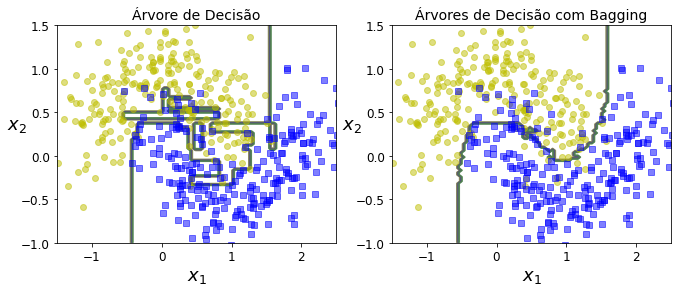

In [21]:
eixos = [-1.5, 2.5, -1, 1.5]

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y, eixos)
plt.title('Árvore de Decisão', fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y, eixos)
plt.title('Árvores de Decisão com Bagging', fontsize=14)

plt.show()

Como podemos notar, as previsões do ensemble possivelmente generalizarão muito melhor do que as previsões da Árvore de Decisão: o ensemble possui um viés comparável, mas uma variância menor, faz com que o mesmo número de erros ocorra no conjunto de treino, mas o limite de decisão é menos irregular.

O bootsraping introduz um pouco mais de diversidade nos subconjuntos em qe cada classificador é treinado, então bagging acaba com um viés um pouco mais alto do que pasting, mas isto também diz que os previsores acabam sendo menos correlatos, logo, a variância do ensemble é reduzida. De modo geral, bagging resulta em melhores modelos, o que explica por que em geral é escolhido. Todavia, se tivermos tempo livre e uma CPU parruda, podemos usar a validação cruzada para avaliar tanto o bagging quanto o pasting e selecionaremos o que funcionar melhor.

**Avaliação Out-of-Bag**

Com o bagging, algumas instâncias podem ser amostradas diversas vezes em qualquer previsor, enquanto outras podem nem serem amostradas. Por padrão, um classificador bagging amostra *m* instâncias de treino com substituição (**bootstrap=True**), sendo *m* o tamanho do conjunto. Isso significa que 63% das instâncias de treino são amostradas em média para cada previsor. Os 37% restantes que não são amostradas são chamadas de instâncias *out-of-bag* (oob). Vale ressaltar que elas não são os mesmos 37% para todos os previsores.

Como um previsor nunca analisa as instâncias oob durante o treino, ele pode ser avaliado nessas instâncias sem precisar de um conjunto de validação separado ou validação cruzada. Podemos avaliar o enemble em si com a média das avaliações oob de cada classificador.

Podemos configurar no classificador bagging com o hiperparâmetro **oob_score** como *True* para uma avaliação oob automática após o treino. O código abaixo demonstra isto. A pontuação da avaliação resultante está disponível na variável **oob_score_**:

In [22]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(random_state=42), n_estimators=500,
bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)

In [23]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=40)

In [24]:
bag_clf.oob_score_

0.8986666666666666

De acordo com a avaliação oob, este classificador bagging pode obter uma acurácia de aproximadamente 89,9% no conjunto de teste. Vamos ver:

In [25]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Conseguimos um belo 91,2% de acurácia no conjunto de teste, bem perto do previsto pela teoria.

A função de decisão oob para cada instância de treino também está disponível através da variável **oob_decision_function_**. Neste caso, a função de decisão retorna as probabilidades da classe para cada instância de treino. Por exemplo, a avaliação oob estima que a primeira instância de treino possui a probabilidade de 67,7% pertecer à classe positiva e 32,3% de ser da classe negativa:

In [26]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

### Patches Aleatórios e Subespaços Aleatórios

A classe **BaggingClassifier** permite também a amostragem das características, que é controlada pelos hiperparâmetros **bootstrap_features** e **max_features**. Esses dois hiperparâmetros trabalham da mesma maneira que o **bootstrap** e o **max_samples**, porém para a amostragem da característica, não para a da instância. Desse modo, cada classificador será treinado em um subconjunto aleatório das características da entrada.

Isso é bem útil quando lidadmos com entradas de alta dimensionalidade (como imagens). A amostragem das instâncias de treino e das características é conhecida como médodo *Rnadom Patches* Quando mantemos todas as instâncias de treino (**bootstrap=True** e **max_samples=1.0**), exceto as características de amostragem (**bootstrap_features=True** e o **max_features** menor que 1), são conhecidas como método *Random Subspaces*.

As características da amostragem retornam uma maior diversidade dos previsores, trocando um pouco mais de viés por uma menor variância.

### Florestas Aleatórias

Como já mencionado, uma Floresta Aleatória é um ensemble de Árvores de Decisão, na maioria das vezes treinado pelo método bagging (alguma vezes pelo pasting) com o hiperparâmetro **max_samples** ajustado ao conjunto de treino. Ao invés de construir um **BaggingClassifier** e passá-lo por um **DecisionTreeClassifier**, podemos usar a classe **RandomForestClassifier**, que é mais conveniente e otimizada para Árvores de Decisão; além de diminuir a chance de erros (quando n coisas envolvidas para uma ação, a chance de dar errado é de n vezes). Há também o **RandomForestRegressor** para as tarefas de regressão. O código abaixo treina uma Floresta Aleatória com 500 árvores (cada uma com no máximo 16 nós), usando todos os núcleos de CPU disponíveis:

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rdn_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16, n_jobs=-1,
                                random_state=42)
rdn_clf.fit(X_train, y_train)

y_pred_rf = rdn_clf.predict(X_test)

Com poucas exceções, um classificador de Floresta Aleatória possui todos os hiperparâmetros de um **DecisionTreeClassifier** (para controlar como as árvores se desenvolvem) mais todos os hiperparâmetros de um classificador bagging para controlar o próprio ensemble.

O algoritmo Floresta Aleatória apresenta uma aleatoriedade extra ao desenvolver as árvores; ao invés de buscar a melhor característica quando divide um nó, ele a busca entre um subconjunto aleatório dessas características, resultadno em uma grande diversidade da árvore, que (de novo) prefere um alto víes do que uma baixa variância, normalmente gerando um melhor modelo no geral. O **BaggingClassifier** abaixo é equivalente ao **RandomForestClassifier** feito anteriormente:

In [29]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter='random', max_leaf_nodes=16,
                      random_state=42),
n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1,
random_state=42)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

In [30]:
# Ver a acurácia de previsões entre ambos os classificadores
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

In [31]:
# Acurácia de ambos
acuracia_rnd_clf = accuracy_score(y_test, y_pred_rf)
acuracis_bag_clf = accuracy_score(y_test, y_pred)
print(f'RandomForestClassifier: {acuracia_rnd_clf:.1%}')
print(f'BaggingClassifier: {acuracis_bag_clf:.1%}')

RandomForestClassifier: 91.2%
BaggingClassifier: 92.0%


**Árvores-Extras**

Quando desenvolvemos uma Floresta Aleatória, devemos considerar um subonjunto aleatório para a divisão das características em cada nó. É possível tornar as árvores ainda mais aleatórias ao usarmos os limiares aleatórios para cada característica em ao invés de buscar pelo melhot limiar possível, como fazem as Árvores de Decisão.

As florestas aleatórias tão extremas é conhecida como ensemble de *Árvores Extremamente Aleatórias*, ou *Árvores-Extras* na abreviação. Novamente, isto troca um viés maior por uma variância menor. Também torna o treino das Árvores-Extras mais rápido do que as Florestas Aleatórias regulares, uma vez que enontrar o melhor limiar possível para cada característica em cada nó é uma das tarefas que mais demandam tempo no desenvolvimento de uma árvore.

Podemos criar um classificador de Árvores-Extras com a classe **ExtraTreesClassifier**, ele segue a mesma API de **RandomForestClassifier**. Árvores-Extras também possui uma classe para tarefas de regressão, e também possui a mesma API para que a regressão da Floresta Aleatória.

A priori, é complicado dizer se um classificador de Floresta Aleatória será melhor do que um de Árvores-Extras. Normalmente, só saberemos se compararmos os previsores com a validação cruzada e ajustando os hiperparâmetros com a grid search.

**Importância da Característica**

Outra qualidade ótima das Florestas Aleatórias é que elas ajudam a medição das importância relativa de cada característica. O Scikit-Learn mede a importância de uma característica analisando o quanto os nós da árvore que a utilizam reduzem, em média, a impureza. Mais precisamente, é uma média ponderada em que o peso de cada nó é igual ao número de amostras treinadas que são associadas a ela.

O Scikit-Learn calcula de modo automático esta pontuação para cada característica depois do treino, em seguida dimensiona os resultados para que a soma de todas as importâncias seja igual a 1. Podemos acessar o resultado usando a vairável **feature_importances_**. Por exemplo, o código abaixo treina um **RandomForestClassifier** no com os dados da íris e mostra cada importância dessa característica. Parace que as característias mais importantes são o comprimento da pétala (44%) e a largura(42%), enquanto a largura da sépala (11%) e o comprimento (2%) são menos importantes:

In [32]:
from sklearn.datasets import load_iris

In [33]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1,
                                random_state=42)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'],
                      rnd_clf.feature_importances_):
    print(f'{name}: {score:.0%}')

sepal length (cm): 11%
sepal width (cm): 2%
petal length (cm): 44%
petal width (cm): 42%


Do mesmo modo, é possível saber a importância de cada pixel em uma imagem com um calssificador de Floresta Aleatória. Para exemplificar, usaremos o conjunto MNIST no código abaixo:

In [34]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1,
                         as_frame=False)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [35]:
rnd_clf = RandomForestClassifier(n_estimators=10,
                                 random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(n_estimators=10, random_state=42)

In [36]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.hot,
              interpolation='nearest')
    plt.axis('off')

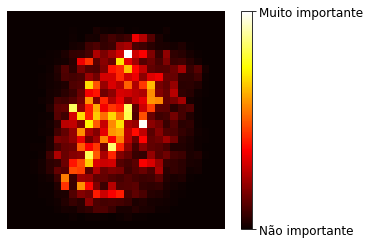

In [37]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                          rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Não importante', 'Muito importante'])

plt.show()

As Florestas Aleatórias são extremamente úteis se precisamos entender de modo simples e rápido quais características realmente importam, principalmente se precisarmos realizar alguma seleção.

### Boosting

*Boosting* (conhecido anteriormente como *hypothesis boosting*) refere-se a qualquer método Ensemble que agrupa diversos aprendizes fracos em um forte. A ideia por trás dos métodos boosting é treinar sequencialmente os previsores, cada um tentando corrigir as falhas do anterior. Há diversos métodos boosting disponíveis, porém os mais populares são o *AdaBoost* (abreviação de *Adaptive Boosting*) e *Gradient Boosting*.

**AdaBoost**

Uma maneira de o previsor seguinte corrigir o anterior é prestar um pouco mais de atenção nas instâncias de treino que o modelo anterior subajustou. Isto retorna um novos previsores focando mais e mais em *cases difíceis*.

Por exemplo, para construir um classificador AdaBoost, treinamos um classificador de primeira base e o usamos para faer previsões no conjunto de treino. O peso relativo das instâncias de treino classificadas equivocadamente é aumentado. Um segundo classificador é treinado com a utilização dos pesos atualizados e de novo ele realiza previsões no conjunto de treino, os pesos são atualizados e assim por diante.

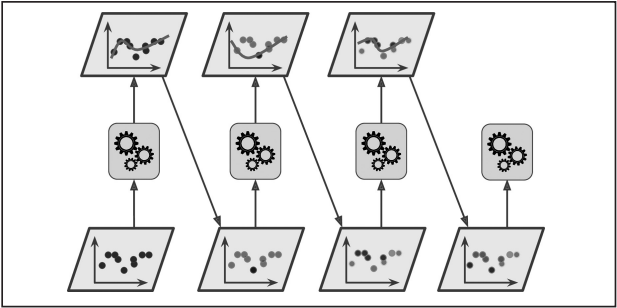

***Figura 7-4. Treinamento sequencial AdaBoost com atualizações de pesos das instância.***

As plotagens abaixo mostram os limites de decisão de cinco classificadores consecutivos no conjunto de dados de lua (neste exemplo, cada previsor é um classificador SVM altamente regularizado com um kernel *RBF*. Normalmente não são usados os SVMs para o AdaBoost, pois ficam lentos e instáveis com o AdaBoost; será usado somente para fins ilustrativos). O primeiro classificador recebe muitas instâncias equivocadas, o que faz os pesos aumentarem. O segundo classificador, porém, realiza um trabalho melhor nessas instâncias, o terceiro; melhor ainda, e assim por diante. A imagem da direita representa a mesma sequência de classificadores, exceto que a taxa de aprendizado é reduzida pela metade, isto é: os pesos das instâncias classificadas de maneira errada são aumentados em 50% a cada nova interação. Como podemos notar, esta técnica de aprendizado sequencial possui algumas semelhanças com o Gradiente Descendente, com a exceção que, ao invés de ajusar os parâmetros de um único previsor para minimizar uma função de custo, o AdaBoost adiciona classificadores ao ensemble, tornando-o gradualmente melhor:

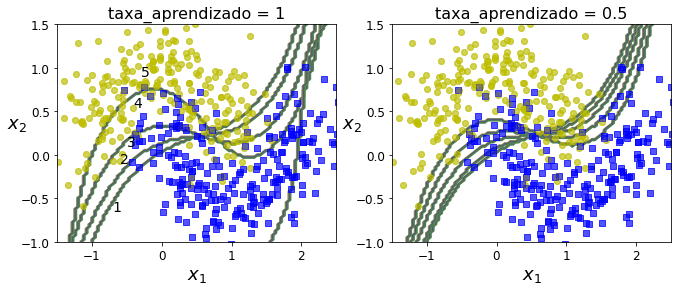

In [38]:
m = len(X_train)
eixos = [-1.5, 2.5, -1, 1.5]

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.05, gamma='auto',
                     random_state=42)
        svm_clf.fit(X_train, y_train,
                    sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1+learning_rate)
        plot_decision_boundary(svm_clf, X, y, eixos, alpha=0.2)
        plt.title(f'taxa_aprendizado = {learning_rate}',
                 fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
        
plt.show()

Quando todos os classificadores esntão treinados, o ensemble realiza previsões bem parecidas com o bagging ou pasting, mas os classificadores possuem pesos diferentes dependendo da precisão geral no conjunto de treino ponderado.

Mas nem tudo são flores. Há uma desvantagem para essa técnica de aprendizado sequencial: ela não pode ser paralelizada, uma vez que cada classificador só pode ser treinado quando classificador anterior tiver sido treinado e avaliado. Por conta disso, ele não escalona tão bem como o bagging ou o pasting.

Vamos analisar o algoritmo do AdaBoost. Cada peso *w^(i)* da instância é inicialmente definido em *1/m*. O primeiro classificador é treinado e sua taxa de erro ponderado *r1* é calculada no conjunto de treino.

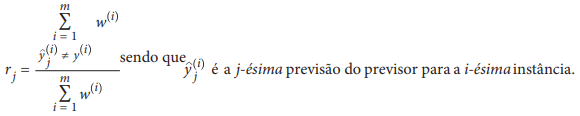

***Equação 7-1. Taxa de erro ponderada do j-ésimo previsor***

Usando a equação abaixo, o peso *αj* do classificador é calculado, sendo que *η* é o hiperparâmetro da taxa de aprendizado (o padrão é 1). Quanto mais preciso for o classificador, mais alto é o peso. Se ele apenas retornar valores aleatoriamente, o seu peso será próximo de zero. Contudo, se ele errar com mais frequência, ou seja, com menos acurácia do que os valores aleatórios, então o peso será negativo.

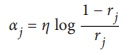

***Equação 7-2. Peso do previsor***

Os pesos das instâncias são usadas na equação a seguir: as instâncias classificadas equivocadamente são aumentadas.

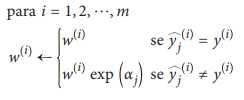

***Equação 7-3. Regra da atualização do peso***

Logo, todos os pesos das instâncias são normalizados, ou seja, dividitos por 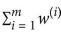

Por fim, um novo classificador é treinado usando os pesos atualizados e todo o processo é repetido. O algoritmo para quando o número de previsores é alcançado ou quando um classificador perfeito é encontrado.

Para realizar previsões, o AdaBoost simplesmente calcula as previsões de todos os classficadores e os pondera usando os pesos *αj* dos mesmos. A classe do previsor é aquela que recebe a maior parte dos votos ponderados.

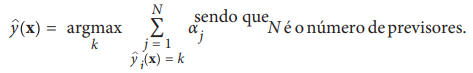

***Equação 7-4. Previsões AdaBoost***

Na verdade, o Scikit-Learn usa uma versão multiclasse do AdaBoost conhecida como *SAMME* (que significa *Stagewise Additive Modeling using a Multiclass Exponential loss function*). O SAMME é equivalente ao AdaBoost quando existem apenas duas classes. Além disso, se os classificadores puderem estimar probabilidades da classe, o Scikit-Learn pode usar uma variante SAMME conhecida como *SAMME.R* (o *R* vem de "Real") que se baseia nas probabilidades da classe em vez das previsões, na maior parte da vezes tendo um melhor desempenho.

O código abaixo treina um classificador AdaBoost baseado em 200 *Decision Stumps* usando a classe **AdaBoostClassifier** (como de costume, também há o **AdaBoostRegressor**. Uma *Decision Stump* é uma Árvore de Decisão com **max_depth=1**, ou seja, uma árvore feita de somente 1 nó de decisão com mais 2 nós de folhas:

In [39]:
from sklearn.ensemble import AdaBoostClassifier

In [40]:
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=200,
algorithm='SAMME.R', learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

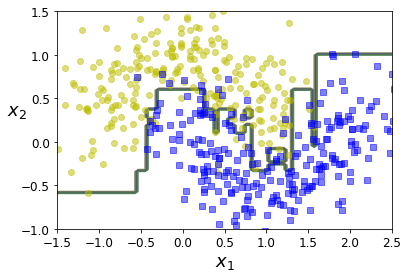

In [41]:
plot_decision_boundary(ada_clf, X, y, [-1.5, 2.5, -1, 1.5])

Se o AdaBoost usado estiver sobreajustando-se ao conjunto de treino, podemos reduzir o número de estimadores ou regularizar mais fortemente o estimador base.

**Gradient Boosting**

Outro algoritmo Boosting muito usado é o *Gradient Boosting*. Do mesmo modo que o AdaBoost, O Gradient Boosting adiciona diversos classificadores sequencialemte a um conjunto, cada um corrigindo o erro do anterior. Todavia, ao invés de ajustar os pesos da instância a cada iteração como o AdaBoost faz, o Gradient Boosting tenta ajustar o novo classificador aos *erros residuais* feito pelo previsor anterior.

Vamos analisar um exemplo de regressão simples com Árvores de Decisão como previsores base. Isto é conhecido como *Gradient Tree Boosting*, ou *Gradietn Boosted Regression Trees* (GBRT). Priemeiro, vmaos ajustar a classe **DecisionTreeRegressor** ao conjunto de treino quadrático ruidoso:

In [42]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

In [43]:
from sklearn.tree import DecisionTreeRegressor

In [44]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Agora vamos treinar um segundo **DecisionTreeRegression** nos erros residuais cometidos pelo previsor anterior:

In [45]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Em seguida, treinaremos um terceiro regressor nos erros residuais cometidos pelo segundo previsor:

In [46]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Agora que temos um ensemble de três árvores, podemos realizar previsões em uma nova instância adicionando as previsões de todas as árvores:

In [47]:
X_new = np.array([[0.8]])

In [48]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,
                                             tree_reg2,
                                             tree_reg3))

In [49]:
y_pred

array([0.75026781])

A plotagem a seguir mostra as previsões dessas três árvores no lado esquerdo e o ensemble do lado direito. Na primeira linha, o ensemble possui apenas uma árvore, logo as previsões são exatamente as mesmas que as previsões da primeira árvore. A segunda linha, uma árvore é treinada com os erros residuais da primeira. Do lado direito é possível observar que as previsões do ensemble são iguais à soma das previsões das duas primeiras árvores. Do mesmo modo, a terceira linha é treinada com os erros residuais da segunda árvore. É possível notar que quanto mais árvores são adicionadas, melhores ficam as suas previsões:

In [50]:
def plot_predictions(regressors, X, y, axes, label=None,
                    style='r-', data_style='b.',
                     data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

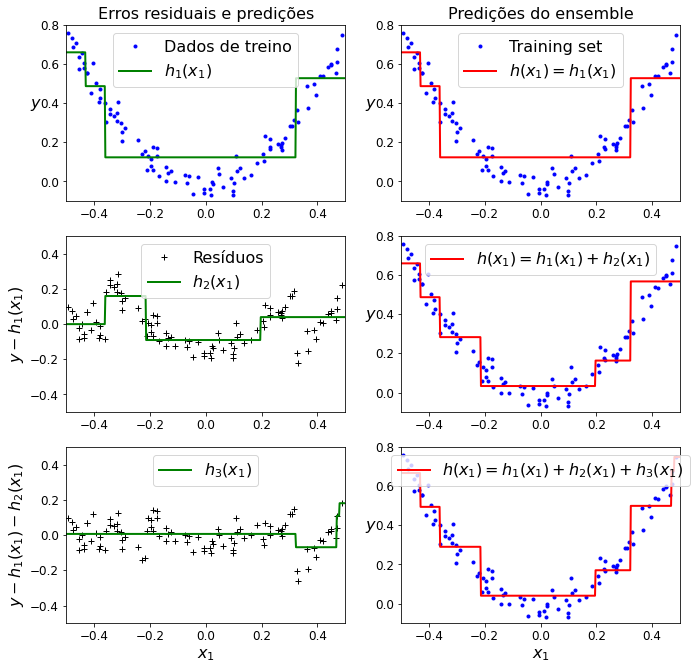

In [51]:
plt.figure(figsize=(11, 11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h_1(x_1)$", style="g-",
                 data_label="Dados de treino")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Erros residuais e predições", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1)$",
                 data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Predições do ensemble", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2,
                 axes=[-0.5, 0.5, -0.5, 0.5],
                 label="$h_2(x_1)$", style="g-",
                 data_style="k+", data_label="Resíduos")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3,
                 axes=[-0.5, 0.5, -0.5, 0.5],
                 label="$h_3(x_1)$", style="g-",
                 data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8],
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

Um jeito simples de treinar ensembles GBRT seria com o uso da classe **GradientBoostingRegressor** do Scikit-Learn. Assim como o **RandomForestRegressor**, ela possui hiperparâmetros capazes de controlar o crescimento das Árvores de Decisão, bem como hiperparâmetros para controlar o treino do ensemble, como o número de árvores. O código abaixo cria o mesmo ensemble que o anterior:

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

In [53]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                        learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

O hiperparâmetro **learning_rate** escalona a contribuição de cada árvore. Se configurarmos esse hiperparâmetro para um valor baixo (como 0,1), precisaríamos de mais árvores no ensemble para se ajustar melhor no conjunto de treino, mas as previsões normalmente generalizarão melhor. Esta é uma t´cnica de regularização conhecida como *encolhimento*. A plotagem abaixo apresenta dois ensembles GBRT treinados com uma baixa taxa de aprendizado: do lado esquerdo não tem árvores sufcientes para que se ajustem ao conjunto de treino, enquanto do lado direito possui muitas árvores e sobreajusta-se ao dados de treino:

In [54]:
gbrt_slow = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=200,
                                     learning_rate=0.1,
                                     random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

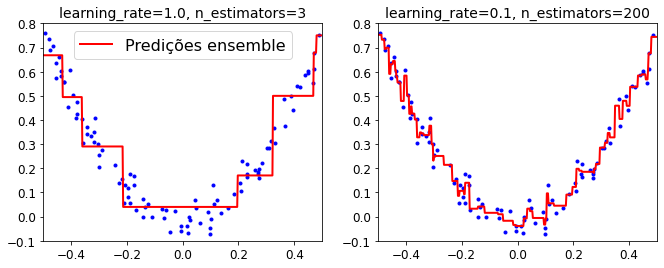

In [55]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8],
                 label='Predições ensemble')
plt.title(f'learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators}',
          fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f'learning_rate={gbrt_slow.learning_rate}, n_estimators={gbrt_slow.n_estimators}',
          fontsize=14)


plt.show()

Podemos usar a parada antecipada para encontrar o número ideal de árvores. Um modo fácil de implementar isso é com a tilização do método **staged_predict()**: ele devolve um interador em cada estágio do treino sobre as previsõs realizadas pelo ensemble. O código abaixo treina um ensemble GBRT com 120 árvores e mede o erro de validação de cada estágio do treino para encontrar o número ideal de árvores e com esse número, ele treina outro ensemble GBRT:

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [57]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120,
                                random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=bst_n_estimators,
                                     random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [58]:
min_error = np.min(errors)

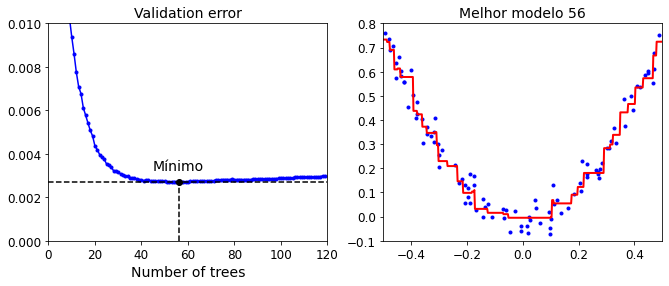

In [59]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error],
         "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Mínimo",
         ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y,
                 axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"Melhor modelo {bst_n_estimators}", fontsize=14)

plt.show()

Também é possível implementar a parada antecipada interrompendo o treino, ao invés de treinar uma grande quantidade de árvores e em seguida olhar para trás e achar o número ideal. Podemos fazer isso configurando **warm_start** como *True*, o que indica ao Scikit-Learn para manter as árvores existentes quando chamarmos o **fit()**, permitindo um treino incremental. O código abaixo para o treinamento quando o erro de validação não melhora por 5 iterações seguidas:

In [60]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True,
                                random_state=42)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # parada antecipada

In [61]:
print(gbrt.n_estimators)

61


In [62]:
print(f'MSE: {min_val_error}')

MSE: 0.002712853325235463


A classe **GradientBoostingRegressor** também suporta o hiperparâmetro **subsample**, que indica a fração das instâncias de treino a serem sadas para treinar cada árvore. Por exemplo, se **subsample=0.25**, cada árvore treinará com 25% das instâncias de treino selecionadas de modo aleatório. Como podemos perceber, isso troca um viés maior por uma variância menor. Isso também acelera significativamente o treino. Esta técnica é conhecidad como *Stochastic Gradient Boosting*.

É possível usar o Gradient Boosting com outras fnções de custo. Isso é controlado pelo hiperparâmetro **loss**.

### Stacking

Veremos agora o último Ensemble method conhecido como *stacking* (abreviação de *stacking generalization*). Esse ensemble baseia-se em uma simples ideia: ao invés de usar funções comuns (como hard voting) para agregar as previsões de todos os classificadores em um conjunto, por que não treinamos um modelo para agregá-las? A imagem abaixo exemplifica essa ideia com uma tarefa de regressão em uma nova instância. Cada um dos três classificadores prevê um valor diferente (3,1; 2,7 e 2,9) e, em seguida, o classificador final (conhecido como *blender* o *meta learner*) pega essas previsões como entrada e retorna a previsão final (3,0).

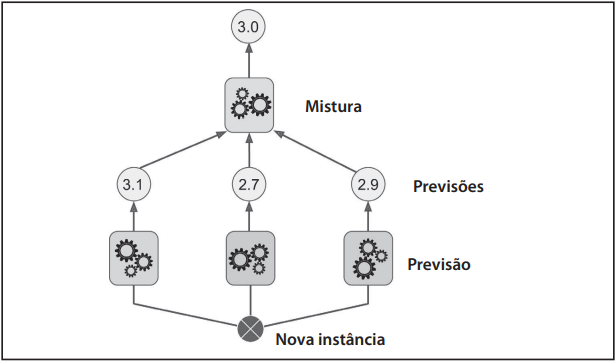

***Figura 7-5. Agregando previsores com um previsor blender***

Uma maneira comum é usar um conjunto hold-out para treinar o blender. Primeiro, o conjunto de treino é separado em dois subconjuntos. O primeiro subconjunto é usado para treinar os previsores na primeira camada.

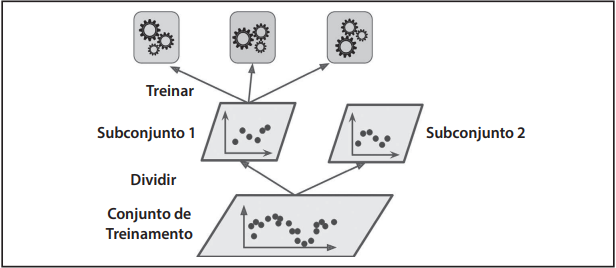

***Figura 7-6. Treinando a primeira camada***

Na sequência, os previsores da primeira camada são usados para realizar previsões no segundo cojunto (hold-out), o que assegura que as previsões sejam "limpas", já que os classificadores nnca viram essas instâncias durante o treino. Agora, há três valores previstos para cada instância do conjunto hold-out e usando-os como características de entrada, podendo assim, criar um novo conjunto de treino (esse conjunto torna-se tridimensional) e manter os valores de destino. O blender é treinado neste novo conjunto de treino, aprendendo a prever o valor alvo dadas as previsões da primeira camada.

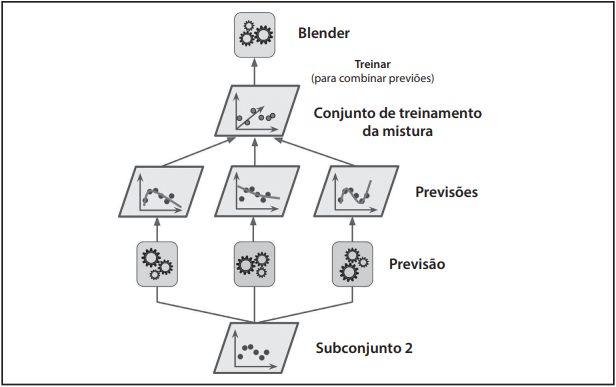

***Figura 7-7. Treinando o blender***

Na verdade, é possível treinar diversos blenders distintos desse modo (por exemplo, um usando Regressão de Floresta Aleatória, outro com Regressão Linear, com Regressão Logística, e assim por diante), recebendo uma camada completa de blenders. O truque é separar o conjnto de treino em três subconjuntos: o primeiro para treinar a primeira camada, o segundo para criar o conjunto de treino usado para treinar a segunda camada e o terciro para criar um conjnto de treino para treinar a terceira camada. Uma vez feita essa divisão, podemos realzar uma previsão para uma nova instância passando sequencialmente por cada camada.

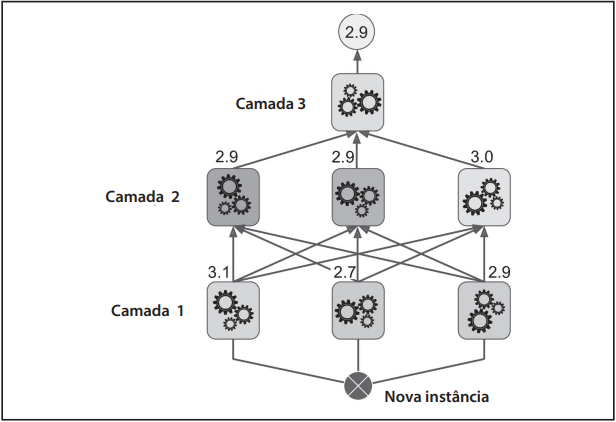

***Figura 7-8. Previsões em um ensemble stacking de multicamadas***

Por incrível que paraça, o Scikit-Learn não suporta stacking diretamente, mas não é complicado fazer a nossa própria implementação. Como alternativam podemos usar uma implementação de código aberto como o **DESlib** (https://github.com/Menelau/DESlib).

### Exercícios

**1. Se você treinou cinco modelos diferentes com exatamente os mesmos dados de
treinamento e todos conseguem uma precisão de 95%, existe alguma chance de
você combinar esses modelos para obter melhores resultados? Em caso afirmativo, como? Se não, por quê?**

Podemos tentar combiná-los em um ensemble de votação se treinamos cinco modelos distintos e todos chegam a 95% d epresição, o que nos retornará valores ainda melhores. Ele funciona melhor se os modelos forem bem distintos, como um classificador SVM, uma Árvore de Decisão, uma Regressão Logística e assim vai. Fica ainda melhor se eles forem treinados em diferentes instâncias de treino, mas funcionará bem mesmo que não sejam treinados; desde que sejam algoritmos bem distintos.

**2. Qual a diferença entre os classificadores de votação hard e soft?**

Um classificador de votação hard apenas conta os votos de cada classificador no ensemble e escolhe a classe que retorna o maior número de votos. Um classificador de votação soft calcula a probabilidade da classe média estimada para cada classe e escolhe a com maior probabilidade. Isso entrega votos de alta confiança, maiores pesos, e normalmente possui melhor desempenho, mas funciona somente se cada classificador for capaz de estimar as probbabilidades da classe.

**3. É possível acelerar o treinamento de um bagging ensemble distribuindo-o por vários
servidores? E com pasting ensembles, boosting ensembles, florestas aleatórias, ou
stacking ensembles?**

É possível acelerar o treino de um conjunto de bagging ensemble fornecendo-o para vários servidores, uma vez que cada previsor no conjunto é independente dos outros. Pelo mesmo motivo, isso vale para pasting ensemble e Florestas Aleatórias. Contudo, cada classificador em um ensemble de reforço é criado com base no previsor anterior, logo o treino é necessariamente sequencial e não ganharemos nada se distribuírmos para diversos servidores. Falando no stacking ensembles, todos os classificadores em uma determinada camada são idependentes uns dos outros para que possam ser treinados em paralelo em diferentes servidores. Porém, os previsores em uma camada só podem ser treinados depois que todos os classificadores da camada anterior tiverem sido treinados.

**4. Qual é o benefício da avaliação out-of-bag?**

Com a avaliação out-of-bag, cada classifiador em um bagging ensemble é avaliado com o uso de instâncias nas quais ele nunca viu, possibilitando uma avaliação bem imparcial do ensemble sem a necessidade de um ensemble a mais de validação. Desse modo, teremos mais instâncias disponíveis para o treino, e nosso ensemble terá um melhor desempenho.

**5. O que torna as Árvores-Extras mais aleatórias do que as Florestas Aleatórias
comuns? Como esta aleatoriedade extra pode ajudar? As Árvores-Extras são mais
lentas ou mais rápidas do que as Florestas Aleatórias regulares?**

Quando usamos as Florestas Aleatórias, é considerado apenas um subconjunto aleatório das características para a divisão em cada nó. Iso também é aplicado às Árvores-Extras, mas elas vão além: ao invés de procrar os melhores limiares possíveis, como ocorre com as árvores de decisão comuns, as Árvores-Extras usam limiares aleatórios para cada característica. Essa aleatoriedade extra atua como uma forma de regularização: esse algoritmo pode ter um melhor desempenho se uma Floresta Aleatória sobreajusta-se aos dados de treino. Além disso, como as Árvores-Extras não buscam os melhores limiares possíveis, elas são bem mais rápidas no treino se comparadas com as Florestas Aleatórias. Todavia, quando fazem previsões, as Árvores-Extras e Florestas Aleatórias levam o mesmo tempo.

**6. Se o seu ensemble AdaBoost se subajusta aos dados de treinamento, quais hiperparâmetros você deve ajustar e como?**

Se está ocorrendo o subajuste nos dados de treino com o ensemble AdaBoost, podemos amentar o número de estimadores ou redzir os hiperparâmertos de reglarização do estimador base. Podemos também tentar aumentar um pouco a taxa de aprendizado.

**7. Se o seu ensemble Gradient Boosting se sobreajusta ao conjunto de treinamento,
você deve aumentar ou diminuir a taxa de aprendizado?**

Se estiver ocorrendo o sobreajuste nos dados de treino com o ensemble Gradient Boosting, deveriamos diminuir a taxa de aprendiado ou usar a parada antecipada para encontrar o número correto de previsores.

**8. Carregue os dados MNIST (introduzido no Capítulo 3) e o divida em um conjunto de
treinamento, um conjunto de validação e um conjunto de teste (por exemplo, utilize
50 mil instâncias para treinamento, 10 mil para validação e 10 mil para teste). Em seguida, treine vários classificadores como um classificador Floresta Aleatória, um classificador Árvores-extra e um SVM. Em seguida, utilizando um classificador de votação soft ou hard, tente combiná-los em um ensemble que supere todos no conjunto de
validação. Uma vez tendo encontrado o ensemble, teste-o no conjunto de teste. Qual é
a melhoria de desempenho em comparação com os classificadores individuais?**

O MNIST já foi carregado durante o estudo.

In [63]:
from sklearn.model_selection import train_test_split

In [86]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
mnist.data, mnist.target, test_size=10000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
X_train_val, y_train_val, test_size=10000, random_state=42)

Treinaremos alguns classificadores: Floresta Aleatória, Árvores-Extra, SVM e MLP:

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [66]:
rnd_for_clf = RandomForestClassifier(n_estimators=10,
                                     random_state=42)
extra_tree_clf = ExtraTreesClassifier(n_estimators=10,
                                     random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [67]:
estimators = [rnd_for_clf, extra_tree_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print(f'Treinando o {estimator}...')
    estimator.fit(X_train, y_train)

Treinando o RandomForestClassifier(n_estimators=10, random_state=42)...
Treinando o ExtraTreesClassifier(n_estimators=10, random_state=42)...
Treinando o LinearSVC(random_state=42)...


D:\Jupyter\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Treinando o MLPClassifier(random_state=42)...


In [68]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9469, 0.9492, 0.8695, 0.9641]

O classificador linear do SVM foi o que teve menos acurácia entr todos. Contudo, vamos mantê-lo por enquanto pois, pois pode melhorar o desepenho do classificador de votação.

Agora, vamos combiná-los em um ensemble para que o resultado final supere os resultados individuais, usando um classeficador de votação hard ou soft:

In [69]:
from sklearn.ensemble import VotingClassifier

In [70]:
named_estimators = [
    ('random_forest', rnd_for_clf),
    ('extra_tree', extra_tree_clf),
    ('svm', svm_clf),
    ('mlp', mlp_clf)
]

In [71]:
voting_clf = VotingClassifier(named_estimators)

In [72]:
voting_clf.fit(X_train, y_train)

D:\Jupyter\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('extra_tree',
                              ExtraTreesClassifier(n_estimators=10,
                                                   random_state=42)),
                             ('svm', LinearSVC(random_state=42)),
                             ('mlp', MLPClassifier(random_state=42))])

In [74]:
voting_clf.score(X_val, y_val)

0.9626

In [75]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9469, 0.9492, 0.8695, 0.9641]

Vamos remover o classificador SVM e ver se a acurácia aumenta. Para retirar um classificador sem ter qe refazer tudo, basta passar **None** para o método **set_params()**:

In [77]:
voting_clf.set_params(svm=None)

VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('extra_tree',
                              ExtraTreesClassifier(n_estimators=10,
                                                   random_state=42)),
                             ('svm', None),
                             ('mlp', MLPClassifier(random_state=42))])

A lista de estimadores foi atualizada:

In [78]:
voting_clf.estimators

[('random_forest', RandomForestClassifier(n_estimators=10, random_state=42)),
 ('extra_tree', ExtraTreesClassifier(n_estimators=10, random_state=42)),
 ('svm', None),
 ('mlp', MLPClassifier(random_state=42))]

Contudo, a lista de estimadores treinados não foi atualizada:

In [79]:
voting_clf.estimators_

[RandomForestClassifier(n_estimators=10, random_state=42),
 ExtraTreesClassifier(n_estimators=10, random_state=42),
 LinearSVC(random_state=42),
 MLPClassifier(random_state=42)]

Para isso, podemos treinar novamente o **VotingClassifier** o deletar o SVM da lista de estimadores treinados:

In [80]:
del voting_clf.estimators_[2]

E vamos avaliar novamente o **VotingClassifier**:

In [81]:
voting_clf.score(X_val, y_val)

0.9648

Um pouco melhor! O SVM estava diminuindo a acurácia. Agora vamos usar a votação soft. Não precisamos fazer todos os passos anteriores para isso, basta informar **soft** ao **voting_clf.voting**:

In [82]:
voting_clf.voting = 'soft'

In [83]:
voting_clf.score(X_val, y_val)

0.9691

É uma melhora considerável, e é muito maior do que os classificadores individuáis.

Por fim, vamos ver qual o desempenho em comparação com os classificadores individuais:

In [87]:
voting_clf.score(X_test, y_test)

0.9695

In [88]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9437, 0.9474, 0.9636]

**9. Execute os classificadores individuais do exercício anterior para fazer previsões
no conjunto de validação e crie um novo conjunto de treinamento com as previsões resultantes: cada instância de treinamento é um vetor que contém o conjunto
de previsões de todos os seus classificadores para uma imagem e o alvo é a classe
da imagem. Parabéns, você acabou de treinar um blender, e, junto com os classificadores, eles formam um stacking ensemble! Agora, avaliaremos o conjunto no
conjunto de testes. Para cada imagem no conjunto de teste, faça previsões com
todos os seus classificadores, então forneça as previsões ao blender para obter as
previsões do ensemble. Como ela se compara ao classificador de votação que você
treinou anteriormente?**

In [89]:
X_val_predictions = np.empty((len(X_val), len(estimators)),
                            dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [90]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [91]:
rnd_for_blender = RandomForestClassifier(n_estimators=200,
                                        oob_score=True,
                                        random_state=42)
rnd_for_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [92]:
rnd_for_blender.oob_score_

0.9608

Agora vamos fornecer a previsão do blander para o ensemble:

In [93]:
X_test_predictions = np.empty((len(X_test), len(estimators)),
                             dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [95]:
y_pred = rnd_for_blender.predict(X_test_predictions)

In [96]:
from sklearn.metrics import accuracy_score

In [97]:
accuracy_score(y_test, y_pred)

0.9627

Esse ensemble stacking não foi tão bem como o de votação soft do exercício anterior, mas ele é tão bom quanto o melhor classificador individual do exercício anterior.

# Término: 15/10/2021